In [36]:
# Load libraries
library(tidyverse)
library(keras)
library(lime)
library(rsample)
library(recipes)
library(yardstick)
library(corrr)
library(readxl)
library(forcats)


**import data**

In [3]:
churn_data_raw <- read_csv("/kaggle/input/bdml-dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")

glimpse(churn_data_raw)

Rows: 7043 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): customerID, gender, Partner, Dependents, PhoneService, MultipleLin...
dbl  (4): SeniorCitizen, tenure, MonthlyCharges, TotalCharges

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 7,043
Columns: 21
$ customerID       <chr> "7590-VHVEG", "5575-GNVDE", "3668-QPYBK", "7795-CFOCW…
$ gender           <chr> "Female", "Male", "Male", "Male", "Female", "Female",…
$ SeniorCitizen    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Partner          <chr> "Yes", "No", "No", "No", "No", "No", "No", "No", "Yes…
$ Dependents       <chr> "No", "No", "No", "No", "No", "No", "Yes", "No", "No"…
$ tenure           <dbl> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, 2…
$ PhoneService     <chr> "No", "Yes", "Yes", "No", "Yes", "Yes", "Yes", "No", …
$ MultipleLines    <chr> "No phone service", "No", "No", "No phone service", "…
$ InternetService  <chr> "DSL", "DSL", "DSL", "DSL", "Fiber optic", "Fiber opt…
$ OnlineSecurity   <chr> "No", "Yes", "Yes", "Yes", "No", "No", "No", "Yes", "…
$ OnlineBackup     <chr> "Yes", "No", "Yes", "No", "No", "No", "Yes", "No", "N…
$ DeviceProtection <chr> "No", "Yes", "No", "Yes", "No", "Yes", "No", "No", "Y…
$ TechSupport   

**Preprocessing**

In [6]:
churn_data_tbl <- churn_data_raw %>%
                  select(-customerID) %>%
                  na.omit(churn_data_raw$TotalCharges) %>%
                  select(Churn, everything())

#churn_data_tbl

**Split data 80/20**

In [9]:
# Split test/training sets
set.seed(100)

train_test_split <- rsample::initial_split(churn_data_tbl, prop = 0.8)
train_test_split

## <Analysis/Assess/Total>
## <5626/1406/7032>

# Retrieve train and test sets
train_tbl <- training(train_test_split)
test_tbl  <- testing(train_test_split)

<Training/Testing/Total>
<5625/1407/7032>

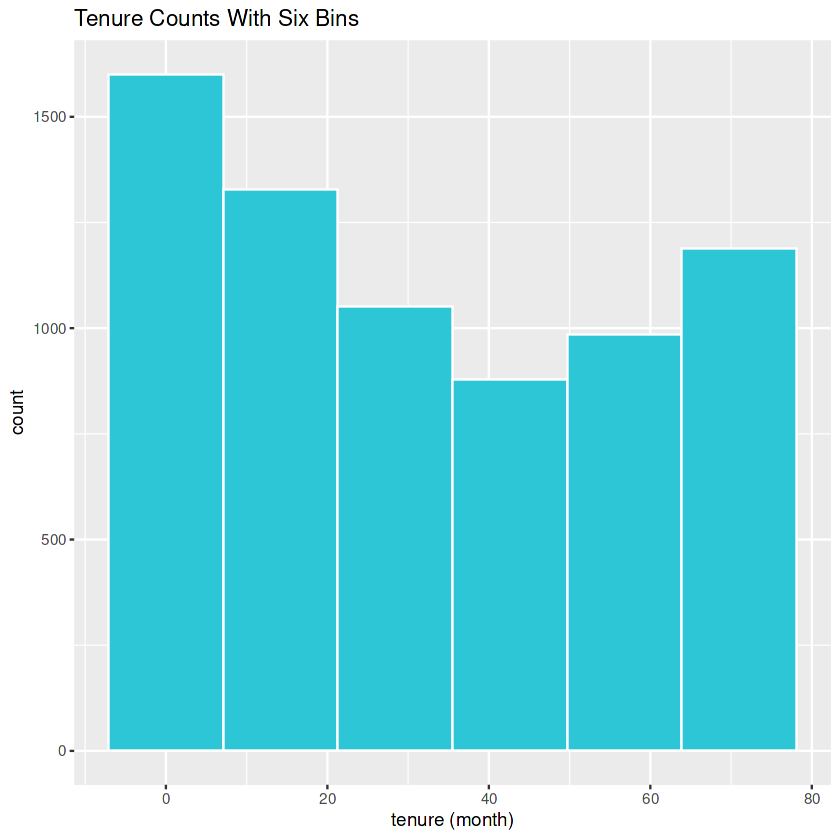

In [11]:
churn_data_tbl %>% ggplot(aes(x = tenure)) + 
  geom_histogram(bins = 6, color = "white", fill =  "#2DC6D6") +
  labs(
    title = "Tenure Counts With Six Bins",
    x     = "tenure (month)"
  )

In [12]:
# Determine if log transformation improves correlation 
# between TotalCharges and Churn

train_tbl %>%
    select(Churn, TotalCharges) %>%
    mutate(
        Churn = Churn %>% as.factor() %>% as.numeric(),
        LogTotalCharges = log(TotalCharges)
        ) %>%
    correlate() %>%
    focus(Churn) %>%
    fashion()

Correlation computed with
• Method: 'pearson'
• Missing treated using: 'pairwise.complete.obs'


term,Churn
<noquote>,<noquote>
TotalCharges,-.21
LogTotalCharges,-.25


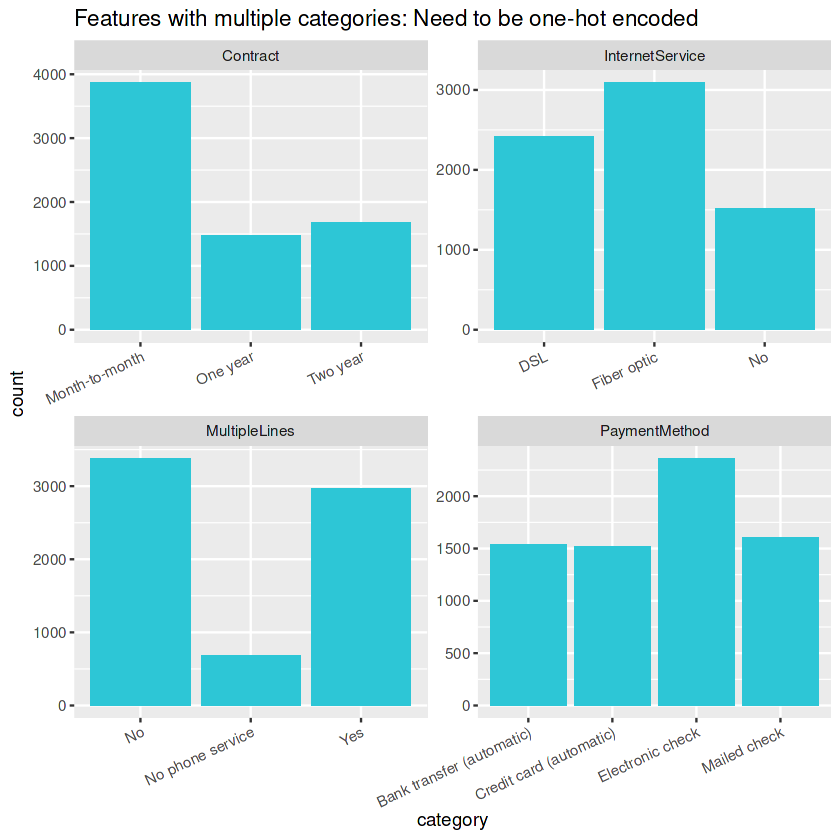

In [13]:
churn_data_tbl %>% 
        pivot_longer(cols      = c(Contract, InternetService, MultipleLines, PaymentMethod), 
                     names_to  = "feature", 
                     values_to = "category") %>% 
        ggplot(aes(category)) +
          geom_bar(fill = "#2DC6D6") +
          facet_wrap(~ feature, scales = "free") +
          labs(
            title = "Features with multiple categories: Need to be one-hot encoded"
          ) +
          theme(axis.text.x = element_text(angle = 25, 
                                           hjust = 1))

**Preprocessing with recipes**

In [14]:
rec_obj <- recipe(Churn ~ ., data = train_tbl) %>%
    step_rm(Churn) %>% 
    step_discretize(tenure, options = list(cuts = 6)) %>%
    step_log(TotalCharges) %>%
    step_dummy(all_nominal(), -all_outcomes(), one_hot = T) %>%
    step_center(all_predictors(), -all_outcomes()) %>%
    step_scale(all_predictors(), -all_outcomes()) %>%
    prep(data = train_tbl)

**Bake**

In [15]:
# Predictors
x_train_tbl <- bake(rec_obj , new_data = train_tbl )
x_test_tbl  <- bake(rec_obj , new_data = test_tbl )

In [16]:
# Response variables for training and testing sets
y_train_vec <- ifelse(churn_data_tbl$Churn == "Yes", 1, 0)
y_test_vec  <- ifelse(test_tbl$Churn == "Yes", 1, 0)

**ANN**

In [17]:
# Building our Artificial Neural Network
model_keras <- keras_model_sequential()

model_keras %>% 
    # First hidden layer
    layer_dense(
        units              = 16, 
        kernel_initializer = "uniform", 
        activation         = "relu", 
        input_shape        = ncol(x_train_tbl)) %>% 
    # Dropout to prevent overfitting
    layer_dropout(rate = 0.1) %>%
    # Second hidden layer
    layer_dense(
        units              = 16, 
        kernel_initializer = "uniform", 
        activation         = "relu") %>% 
    # Dropout to prevent overfitting
    layer_dropout(rate = 0.1) %>%
    # Output layer
    layer_dense(
        units              = 1, 
        kernel_initializer = "uniform", 
        activation         = "sigmoid") %>% 
    # Compile ANN
    compile(
        optimizer = 'adam',
        loss      = 'binary_crossentropy',
        metrics   = c('accuracy')
    )
model_keras

**Training**

In [18]:
# Fit the keras model to the training data
fit_keras <- fit(
    model_keras,
    x = as.matrix(x_train_tbl),
    y = y_train_vec,
    batch_size = 50,
    epochs = 35,
    validation_split = 0.3
)

In [19]:
fit_keras


Final epoch (plot to see history):
        loss: 0.5628
    accuracy: 0.7358
    val_loss: 0.5901
val_accuracy: 0.7346 

**Plot**

`geom_smooth()` using formula = 'y ~ x'


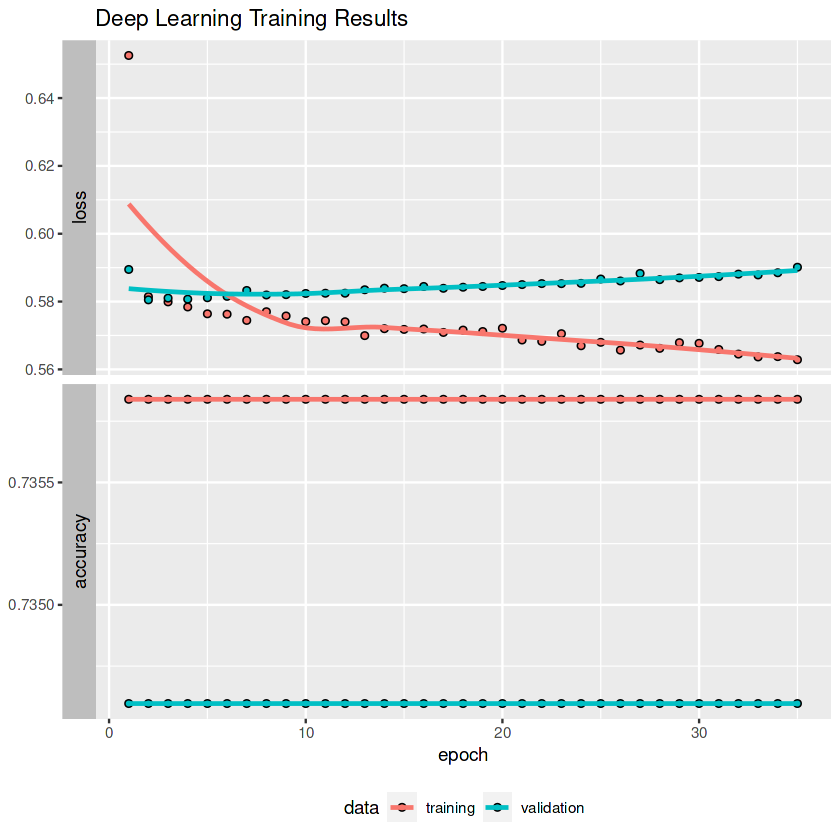

In [23]:
# Plot the training/validation history of our Keras model
plot(fit_keras) +
#geom_smooth(formula = y ~ x, method = "auto", se = FALSE, color = "blue") +
  labs(title = "Deep Learning Training Results") +
  theme(legend.position  = "bottom", 
        strip.placement  = "inside",
        strip.background = element_rect(fill = "grey"))

**Make predictions**
* tensorflow version is different, therefore the code has been adjusted

In [32]:
# Predicted Class
#yhat_keras_class_vec <- predict_classes(object = model_keras, x = as.matrix(x_test_tbl)) %>%
#    as.vector()

# Predicted Class Probability
#yhat_keras_prob_vec  <- predict_proba(object = model_keras, x = as.matrix(x_test_tbl)) %>%
#    as.vector()

# Predicted Class
yhat_keras_class_vec <- predict(object = model_keras, x = as.matrix(x_test_tbl)) %>%
  k_argmax() %>% as.vector()

# Predicted Class Probability
yhat_keras_prob_vec <- predict(object = model_keras, x = as.matrix(x_test_tbl)) %>% as.vector()


**Inspect performance with yardstick**

In [34]:
estimates_keras_tbl <- tibble(
    truth      = as.factor(y_test_vec) %>% fct_recode(yes = "1", no = "0"),
    estimate   = as.factor(yhat_keras_class_vec) %>% fct_recode(yes = "1", no = "0"),
    class_prob = yhat_keras_prob_vec
)



estimates_keras_tbl

Warning message:
“Unknown levels in `f`: 1”


truth,estimate,class_prob
<fct>,<fct>,<dbl>
yes,no,0.3461829
no,no,0.1704325
no,no,0.2249336
no,no,0.2915510
no,no,0.2301756
no,no,0.1059695
no,no,0.2521896
no,no,0.2609118
no,no,0.3870748
